In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [ ]:
#載入檔案
!gdown --id 1_rJ3lZc6hoQMAUCMAAzh07dYQh-CwbH3
!unzip p2_data.zip

In [138]:
dir = './p2_data'
a = os.listdir(dir)
random.shuffle(a)
train_face = []
test_face = []
y_train =[]
y_test = []
p2i1idx = 0 #儲存person2image1的idx
count = 0  #計算person2image1的idx
for idx,i in enumerate(a):
  if i.split('_')[1]=='10.png':
    face = cv2.imread(dir + '/' + i,cv2.IMREAD_GRAYSCALE).astype(np.float64)
    face = face.flatten()
    test_face.append(face)
    y_test.append(i.split('_')[0])
  else:
    if (i.split('.')[0] == '2_1'):
      p2i1idx = count
    face = cv2.imread(dir + '/' + i, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    face = face.flatten()
    train_face.append(face)
    y_train.append(i.split('_')[0])
    count += 1

train_face = np.array(train_face).astype(np.float).T
test_face = np.array(test_face).astype(np.float).T
y_train = np.array(y_train).astype(np.int)
y_test = np.array(y_test).astype(np.int)
print('Training size: ',train_face.shape)
print('Testing size: ',test_face.shape)
print('y_train size:', y_train.shape)
print('y_test size:', y_test.shape)

Training size:  (2576, 360)
Testing size:  (2576, 40)
y_train size: (360,)
y_test size: (40,)


In [139]:
#計算平均值並把train_face & test_face扣掉平均值
mean_vector = train_face.mean(axis=1) # 2576 * 360
for ii in range(train_face.shape[1]):
  train_face[:,ii] -= mean_vector
for ii in range(test_face.shape[1]):
  test_face[:,ii] -= mean_vector

In [140]:
 _,lamb, v = np.linalg.svd(np.dot(train_face.T, train_face))
v = v.T
u = np.dot(train_face,v)
print(u.shape)

(2576, 360)


In [141]:
eigensortindex = np.argsort(-lamb)
print('dominant eigenfaces: ',eigensortindex[:4])

dominant eigenfaces:  [0 1 2 3]


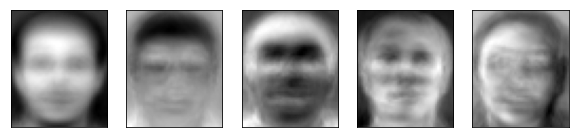

In [142]:
#Plot the first four eigenfaces and mean face
meanface = np.resize(mean,(56,46)).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.subplot(151)
plt.imshow(meanface,cmap ='gray')
plt.xticks([])
plt.yticks([])
for i in range(4):
  plt.subplot(1,5,i+2)
  show_eigenface = np.reshape(u[:,i],(56,46))
  plt.imshow(show_eigenface, cmap = plt.cm.gray)
  plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [143]:
# Normalizing u to ||u||=1
norm = np.linalg.norm(u,axis=0)
u = u / norm

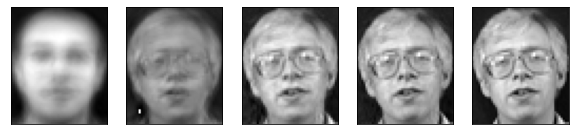

In [144]:
#Reconstruction
weights = np.dot(u.T,train_face) # a1~a40
n = [3,50,170,240,345]
plt.figure(figsize=(10,10))
for idx,i in enumerate(n):
  plt.subplot(1,5,idx+1)
  reconstructed_img = mean + np.dot(weights[:i,p2i1idx], u[:, 0:i].T)
  reconstructed_img = np.resize(reconstructed_img,(56,46)).astype(np.uint8)
  plt.imshow(reconstructed_img, cmap ='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [145]:
#計算原圖與重建圖的MSE值
target_img = train_face.copy()
for i in n:
  square = 0
  reconstructed_img = np.dot(weights[0:i,p2i1idx], u[:, 0:i].T)
  reconstructed_img = np.resize(reconstructed_img,(56,46)).astype(np.float)
  target_img = np.resize(target_img,(56,46,360)).astype(np.float)
  for j in range(56):
    for k in range(46):
      square += np.square(reconstructed_img[j][k] - target_img[j][k][p2i1idx])
  mean_square_error = round(square / (56*46))
  print('%d eigenfaces MSE :'%(i),mean_square_error)

3 eigenfaces MSE : 747.0
50 eigenfaces MSE : 237.0
170 eigenfaces MSE : 47.0
240 eigenfaces MSE : 13.0
345 eigenfaces MSE : 0.0


In [146]:
#K_fold validation
k_fold_face = []
label = []
random.shuffle(a)
for idx,i in enumerate(a):
  if i.split('_')[1]=='10.png':
    continue;
  else:
    face = cv2.imread(dir + '/' + i, cv2.IMREAD_GRAYSCALE)
    face = face.flatten()
    label.append(i.split('_')[0])
    k_fold_face.append(face)
k_fold_face = np.array(k_fold_face).astype(np.float).T
label = np.array(label)
print(k_fold_face.shape)
print(label.shape)

(2576, 360)
(360,)


In [147]:
#K_fold validation
from collections import Counter
n = [3,50,170]
knn = [1,3,5]
k_fold = 3
best_k = 0
best_n = 0
max_acc = 0
for eigennum in n:
  knn1=[]
  knn3=[]
  knn5=[]
  for k in range(k_fold):
    # print('fold %d(n=%d)'%(k,eigennum))
    distance_matrix = np.empty((120,240))

    train_fold = np.concatenate((k_fold_face[:,(k+1)*120:],k_fold_face[:,:k*120]),axis = 1).astype(np.float)
    y_train_fold = np.concatenate((label[(k+1)*120:],label[:k*120]))
    val_fold = k_fold_face[:,k*120:(k+1)*120].astype(np.float)
    y_val = label[k*120:(k+1)*120].astype(np.int)

    k_fold_mean = np.mean(train_fold, axis = 1).astype(np.float)
    k_fold_mean = k_fold_mean[:,np.newaxis]
    train_fold -= k_fold_mean
    val_fold -= k_fold_mean
    
    _,lamb, v_fold = np.linalg.svd(train_fold)
    v_fold = v_fold.T
    u_fold = np.dot(train_fold,v_fold)
    # Normalizing u to ||u||=1
    u_norm = np.linalg.norm(u_fold,axis=0)
    u_fold = u_fold / u_norm

    project_train_fold = u_fold[:,0:eigennum].T.dot(train_fold).T # (240,n)
    project_val = u_fold[:,0:eigennum].T.dot(val_fold).T   # (120,n)
    for i in range(120):
      for j in range(240):
        distance_matrix[i][j] = np.sqrt(np.sum(np.square(project_train_fold[j]-project_val[i])))
    min_disidx = np.argsort(distance_matrix,axis=1) #由小到大

    for k_para in knn:
      
      correct = 0.0
      y_pred = np.empty((120)).astype(np.int)
      for i in range(120):
        k_space = []
        k_space.append(y_train_fold[min_disidx[i,:k_para]])
        k_space = np.array(k_space)
        vote = Counter(k_space[0,:k_para]) 
        count = vote.most_common()    
        y_pred[i] = count[0][0]
        if y_pred[i] == y_val[i]:
          correct += 1
      Accurate = (correct / 120.0) *100
      # print('Accurate of k=%d= '%(k_para),Accurate,'%')
      if str(k_para) == '1':
        knn1.append(Accurate)
      elif str(k_para) == '3':
        knn3.append(Accurate)
      else:
        knn5.append(Accurate)
  print('n=%d'%(eigennum))
  print('Accurate of k=1 ',round(np.mean(knn1),2),'%')
  print('Accurate of k=3 ',round(np.mean(knn3),2),'%')
  print('Accurate of k=5 ',round(np.mean(knn5),2),'%')
  if np.mean(knn1) > max_acc:
    best_k = 1
    best_n = eigennum
    max_acc = round(np.mean(knn1),2)
  if np.mean(knn3) > max_acc:
    best_k = 3
    best_n = eigennum
    max_acc = round(np.mean(knn3),2)
  if np.mean(knn5) > max_acc:
    best_k = 5
    best_n = eigennum
    max_acc = round(np.mean(knn5),2)

print('\n\nBest k=',best_k)
print('Best n=',best_n)
print('Best acc=',max_acc,'%')

n=3
Accurate of k=1  66.11 %
Accurate of k=3  60.56 %
Accurate of k=5  51.67 %
n=50
Accurate of k=1  92.5 %
Accurate of k=3  86.94 %
Accurate of k=5  82.78 %
n=170
Accurate of k=1  93.33 %
Accurate of k=3  86.94 %
Accurate of k=5  81.67 %


Best k= 1
Best n= 170
Best acc= 93.33 %


In [148]:
n=best_n
k=best_k
distance_matrix = np.empty((test_face.shape[1],train_face.shape[1]))
project_train = u[:,0:n].T.dot(train_face).T  # (360,n)
project_test = u[:,0:n].T.dot(test_face).T   # (40,n)
for i in range(test_face.shape[1]):
      for j in range(train_face.shape[1]):
        distance_matrix[i][j] = np.sqrt(np.sum(np.square(project_train[j]-project_test[i])))
min_disidx = np.argsort(distance_matrix,axis=1) #由小到大
correct = 0.0
y_pred = np.empty((test_face.shape[1])).astype(np.int)
for i in range(test_face.shape[1]):
  k_space = []
  k_space.append(y_train[min_disidx[i,:k]])
  k_space = np.array(k_space)
  vote = Counter(k_space[0,:k]) 
  count = vote.most_common()    
  y_pred[i] = count[0][0]
  if y_pred[i] == y_test[i]:
    correct += 1
Accurate = round((correct / 40.0) *100,1)

print('Testing acc =',Accurate,'%')

Testing acc = 95.0 %
